<a href="https://colab.research.google.com/github/Vimalkumar27/ML-Projects/blob/main/HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **House Price Prediction**

## **Load Data**

In [6]:
from google.colab import files
uploaded = files.upload()



Saving train.csv to train.csv


In [7]:
import pandas as pd
df = pd.read_csv("train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### **Checking the DataSet**

In [23]:
# Step: Remove outliers before anything else
df = df[(df['GrLivArea'] < 4500) & (df['SalePrice'] < 500000)]


In [24]:
df.shape  # Rows and columns

df.info()  # Types and nulls

df.describe()  # Summary stats

# Check top 10 columns with missing values
df.isnull().sum().sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
Index: 1449 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1449 non-null   int64  
 1   MSSubClass     1449 non-null   int64  
 2   MSZoning       1449 non-null   object 
 3   LotFrontage    1190 non-null   float64
 4   LotArea        1449 non-null   int64  
 5   Street         1449 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1449 non-null   object 
 8   LandContour    1449 non-null   object 
 9   Utilities      1449 non-null   object 
 10  LotConfig      1449 non-null   object 
 11  LandSlope      1449 non-null   object 
 12  Neighborhood   1449 non-null   object 
 13  Condition1     1449 non-null   object 
 14  Condition2     1449 non-null   object 
 15  BldgType       1449 non-null   object 
 16  HouseStyle     1449 non-null   object 
 17  OverallQual    1449 non-null   int64  
 18  OverallCond  

,0
PoolQC,1444
MiscFeature,1395
Alley,1358
Fence,1169
MasVnrType,871
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


### **Visualize the SalesPrice**

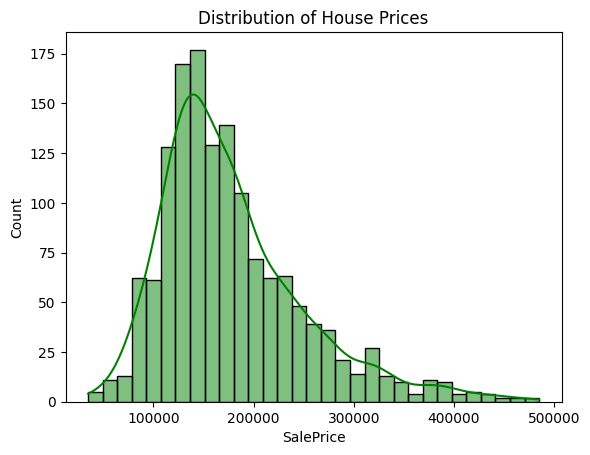

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['SalePrice'], kde=True, color='green')
plt.title("Distribution of House Prices")
plt.xlabel("SalePrice")
plt.show()


### **Removing Categorial Variables**

In [10]:
# Drop 'Id' column, keep only numerical columns
numeric_df = df.select_dtypes(include=['int64', 'float64']).drop('Id', axis=1)

# Check top correlations with SalePrice
correlation = numeric_df.corr()
correlation['SalePrice'].sort_values(ascending=False).head(10)


,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [26]:
# Add categorical features
categorical_cols = ['Neighborhood', 'HouseStyle', 'ExterQual', 'KitchenQual', 'GarageFinish']

# One-hot encode them
df_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)

# Recreate numeric_df to ensure all matches
numeric_df = df.select_dtypes(include=['int64', 'float64']).drop('Id', axis=1)
numeric_df = numeric_df.fillna(numeric_df.mean())

# Add your previously created non-linear features here
numeric_df['GrLivArea_log'] = np.log(df['GrLivArea'] + 1)
numeric_df['OverallQual_squared'] = df['OverallQual'] ** 2
numeric_df['Living_Basement_Ratio'] = df['GrLivArea'] / (df['TotalBsmtSF'] + 1)
numeric_df['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']

# Combine numeric and encoded categorical
numeric_df = pd.concat([numeric_df, df_categorical], axis=1)


### **Missing Values**

In [28]:
# Fill missing values with column mean
numeric_df = numeric_df.fillna(numeric_df.mean())

# Confirm no missing values
numeric_df.isnull().sum().sum()  # Output should be 0


np.int64(0)

In [29]:
import numpy as np

# Add log-transformed feature
numeric_df['GrLivArea_log'] = np.log(numeric_df['GrLivArea'] + 1)

# Add square of OverallQual
numeric_df['OverallQual_squared'] = numeric_df['OverallQual'] ** 2

# Add interaction feature: ratio of living area to basement
numeric_df['Living_Basement_Ratio'] = numeric_df['GrLivArea'] / (numeric_df['TotalBsmtSF'] + 1)

# Add years since remodel
numeric_df['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']


### **Separation of X and y**

In [30]:
X = numeric_df.drop('SalePrice', axis=1)
y = numeric_df['SalePrice']


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## **Model Building**

### **Liner Lasso Ridge (Regression)**

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Create and store models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n{name}")
    print("R² Score:", r2)
    print("RMSE:", rmse)



Linear Regression
R² Score: 0.8903628135816982
RMSE: 23502.96757212828

Ridge Regression
R² Score: 0.8926571722850241
RMSE: 23255.74604589944

Lasso Regression
R² Score: 0.8903839669033647
RMSE: 23500.70013973406


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.228e+11, tolerance: 6.032e+08
  model = cd_fast.enet_coordinate_descent(


### **Residual Plot**

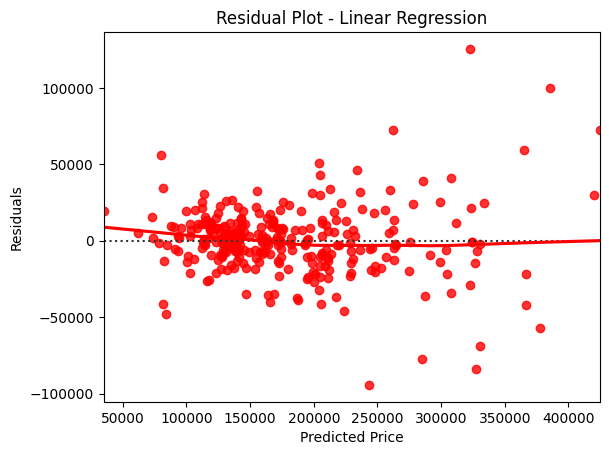

In [34]:
# Residual plot to check prediction errors
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, color="red")
plt.title("Residual Plot - Linear Regression")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.show()


### **Random Forest**

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Create Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)


In [36]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# R² and RMSE
r2_rf = r2_score(y_test, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest R² Score:", r2_rf)
print("Random Forest RMSE:", rmse_rf)


Random Forest R² Score: 0.8609643161267825
Random Forest RMSE: 26467.132961916497


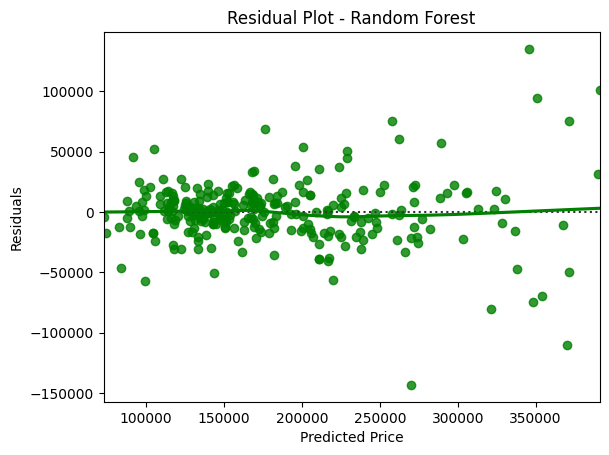

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate residuals
rf_residuals = y_test - rf_pred

# Plot
sns.residplot(x=rf_pred, y=rf_residuals, lowess=True, color="green")
plt.title("Residual Plot - Random Forest")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.show()


In [38]:
# You can compare both R² and RMSE easily
print("🔍 Comparison:")
print(f"Linear Regression R²: {r2_score(y_test, lr.predict(X_test)):.4f}")
print(f"Random Forest R²:      {r2_rf:.4f}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, lr.predict(X_test))):.2f}")
print(f"Random Forest RMSE:     {rmse_rf:.2f}")



🔍 Comparison:
Linear Regression R²: 0.8904
Random Forest R²:      0.8610
Linear Regression RMSE: 23502.97
Random Forest RMSE:     26467.13
